In [171]:
import pandas as pd 

df = pd.read_csv("Kepler_Stars.csv")
df["Star"]

0     Kepler-4
1     Kepler-5
2     Kepler-6
3     Kepler-7
4    Kepler-69
5    Kepler-56
6    Kepler-66
Name: Star, dtype: object

In [172]:
Kepler_Star = "Kepler-5"

In [ ]:
import lightkurve as lk
%matplotlib inline

search_result = lk.search_lightcurve(Kepler_Star , author='Kepler', cadence='long')

lc_collection = search_result.download_all()
lc_collection.plot(); 

In [174]:
lc = lc_collection.stitch().flatten(window_length=901).remove_outliers()
lc.plot()

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

In [ ]:
import numpy as np

period = np.linspace(1, 80, 10000)

bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();
#Power vs Period 

In [176]:
planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
bls.frequency_at_max_power
ax.set_xlim(-5, 5);

In [177]:
bls.period_at_max_power.value

1.7742774277427742

Running burn-in...


100%|██████████| 500/500 [00:13<00:00, 37.62it/s]


Running production...


100%|██████████| 3000/3000 [01:10<00:00, 42.84it/s]


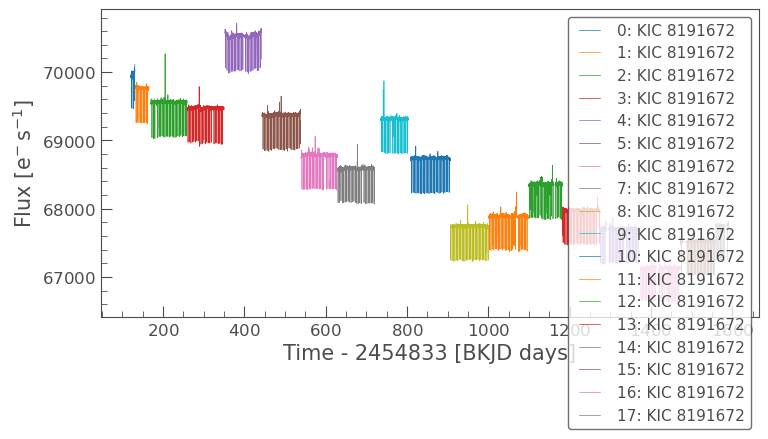

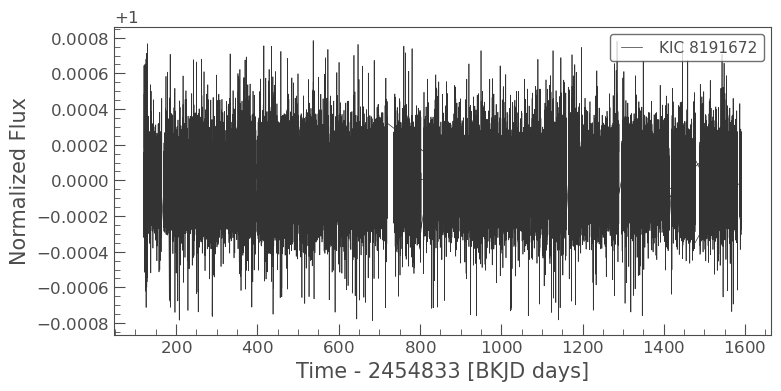

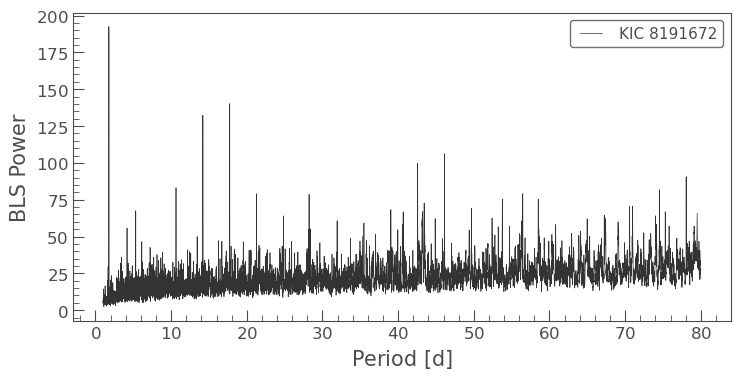

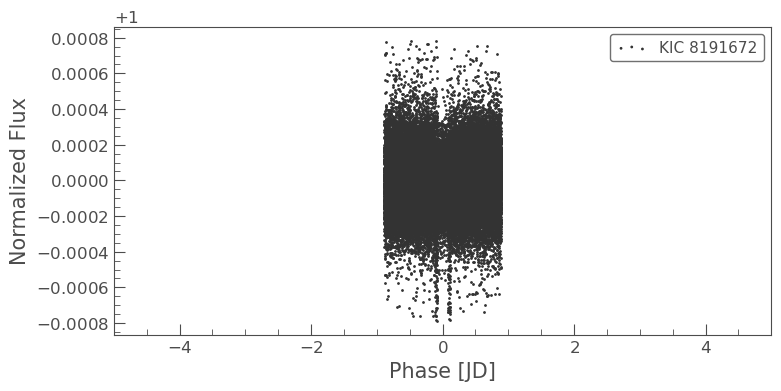

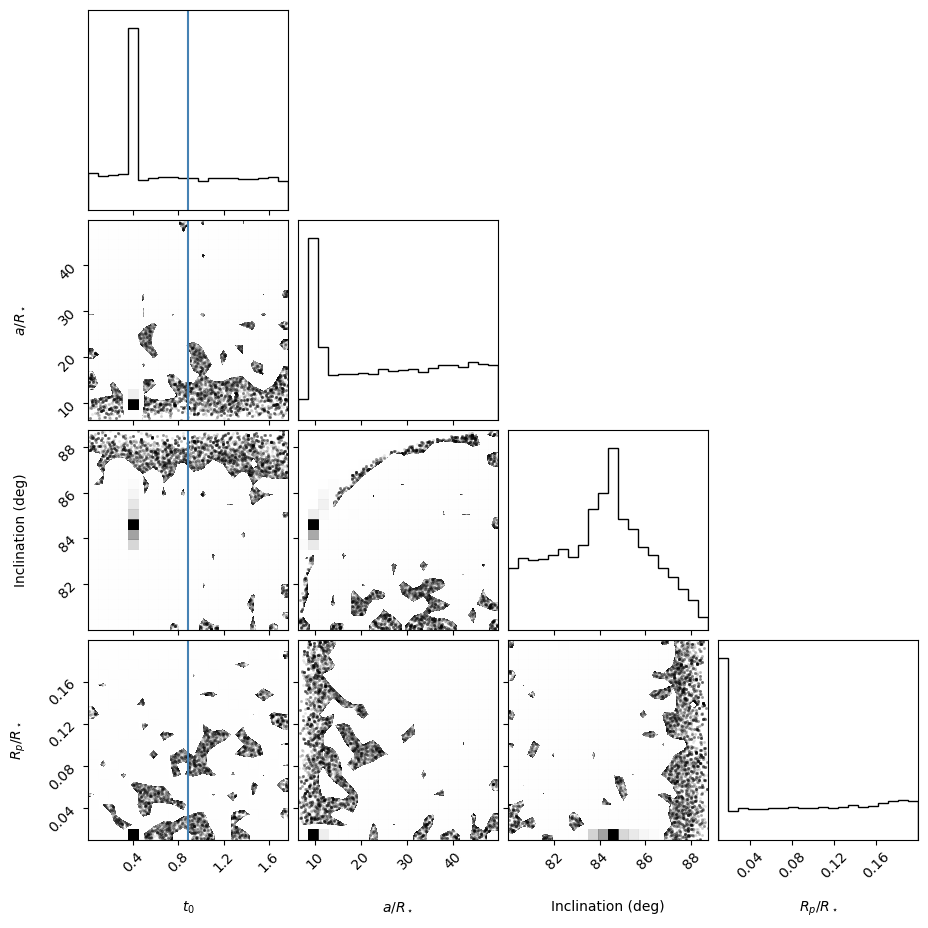

t0: 0.650 days
a/R_star: 26.475
Inclination: 84.224 degrees
R_p/R_star: 0.089


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee



# Known constants and parameters
G = 6.67430e-11  # Gravitational constant, m^3 kg^-1 s^-2
M_sun = 1.989e30  # Solar mass, kg
R_sun = 6.957e8  # Solar radius, m

# Known stellar parameters (replace with actual values)
M_star = 1.0 * M_sun  # Stellar mass, kg
R_star = 1.0 * R_sun  # Stellar radius, m



# Known parameters
period = bls.period_at_max_power.value  # Period of the planet in days
duration = bls.duration_at_max_power.value  # Duration of the transit in days
depth = bls.depth_at_max_power.value# Depth of the transit


time = bls.time.value  
flux = bls.flux.value 
flux_err = lc["flux_err"].value

def create_transit_model(params, time):
    t0, a_Rs, incl, Rp_Rs = params
    bm_params = batman.TransitParams()
    bm_params.t0 = t0 
    bm_params.per = period
    bm_params.rp = Rp_Rs 
    bm_params.a = a_Rs  
    bm_params.inc = incl
    bm_params.ecc = 0.0  
    bm_params.w = 90.0 
    bm_params.u = [0.3, 0.3] 
    bm_params.limb_dark = "quadratic"  # optical effects of the planet appearing brighter 

    m = batman.TransitModel(bm_params, time)
    return m.light_curve(bm_params)



def log_likelihood(params, time, flux, flux_err):
    t0, a_Rs, incl, Rp_Rs = params
    model_flux = create_transit_model(params, time)
    residuals = flux - model_flux
    return -0.5 * np.sum((residuals / flux_err) ** 2)



def log_prior(params):
    t0, a_Rs, incl, Rp_Rs = params
    if 0.0 < t0 < period and 1.0 < a_Rs < 50.0 and 80.0 < incl < 90.0 and 0.01 < Rp_Rs < 0.2:
        return 0.0
    return -np.inf



def log_posterior(params, time, flux, flux_err):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, time, flux, flux_err)
nwalkers = 32
ndim = 4

initial_pos = [[0.5 * period, 10.0, 85.0, 0.1] + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]
sampler = emcee.EnsembleSampler( nwalkers, ndim, log_posterior, args=(time, flux, flux_err))

print("Running burn-in...")
n_burn = 500
pos, prob, state = sampler.run_mcmc(initial_pos, n_burn, progress=True)
print("Running production...")
sampler.reset()
n_steps = 3000
sampler.run_mcmc(pos, n_steps, progress=True)
samples = sampler.get_chain(flat=True)
t0_samples, a_Rs_samples, incl_samples, Rp_Rs_samples = samples.T


import corner

labels = ["$t_0$", "$a/R_\\star$", "Inclination (deg)", "$R_p/R_\\star$"]
fig = corner.corner(samples, labels=labels, truths=[0.5 * period, None, 90.0, None], plot_contours=False)
plt.show()

t0_median = np.median(t0_samples)
a_Rs_median = np.median(a_Rs_samples)
incl_median = np.median(incl_samples)
Rp_Rs_median = np.median(Rp_Rs_samples)

print(f"t0: {t0_median:.3f} days")
print(f"a/R_star: {a_Rs_median:.3f}")
print(f"Inclination: {incl_median:.3f} degrees")
print(f"R_p/R_star: {Rp_Rs_median:.3f}")


In [179]:
df

,Star,Temperature(K),Radius(Solar),Planet_Radius(Jupiter),Planet_Semi_Major_Axis(AU),Orbital_Inclination
0,Kepler-4,5781,1.555,0.3570,0.04560,89.76
1,Kepler-5,6297,1.793,1.4260,0.05380,89.14
2,Kepler-6,5647,1.391,1.3230,0.04567,86.8
3,Kepler-7,5933,1.843,1.4780,0.06224,86.5
4,Kepler-69,5638,0.930,0.1998,0.09400,89.62
5,Kepler-56,4973,4.179,7.8330,0.16520,81.93
6,Kepler-66,5962,0.966,0.2500,0.13520,


In [180]:
print(df[df["Star"] == Kepler_Star]["Radius(Solar)"].values)

semi_major_axis = a_Rs_median*df[df["Star"] == Kepler_Star]["Radius(Solar)"].values*6.957*10e8/(1.496*10e11)
planet_radius = Rp_Rs_median*df[df["Star"] == Kepler_Star]["Radius(Solar)"].values*6.957*10e8/(7.14*10e7)

print(planet_radius, semi_major_axis)


[1.793]
[1.54710985] [0.22075029]
